# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [392]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from collections import defaultdict
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.exceptions import ConvergenceWarning
import warnings







In [394]:
data = pd.read_csv('/Users/uday.kemburu/Documents/Berkley/PAA11_1/data/vehicles.csv')

In [395]:
data.head()


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [400]:
# Explore the columns and the column types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [402]:
#Examine Top 5 columns with the most null values

def print_top_null_columns(df, n=5):
    # Calculate the number of null values in each column
    null_counts = df.isnull().sum()
    
    # Sort the columns by null count in descending order
    sorted_null_counts = null_counts.sort_values(ascending=False)
    
    # Get the top n columns with the most null values
    top_null_columns = sorted_null_counts.head(n)
    
    print(f"Top {n} columns with the most null values:")
    for column, count in top_null_columns.items():
        percentage = (count / len(df)) * 100
        print(f"{column}: {count} null values ({percentage:.2f}% of total)")



# Call the function to print the top 5 columns with null values
print_top_null_columns(data)

Top 5 columns with the most null values:
size: 306361 null values (71.77% of total)
cylinders: 177678 null values (41.62% of total)
condition: 174104 null values (40.79% of total)
VIN: 161042 null values (37.73% of total)
drive: 130567 null values (30.59% of total)


In [404]:
# Count the total number of duplicate rows
duplicate_count = data.duplicated().sum()
print(f"Total number of duplicate rows: {duplicate_count}")
print("-" * 50)

Total number of duplicate rows: 0
--------------------------------------------------


In [406]:
# Examine Unique column values to see if data needs to resolve structural errors
for column in data.columns:
    unique_values = data[column].unique()
    print(f"\nColumn: {column}")
    print(f"Number of unique values: {len(unique_values)}")
    print("Unique values:")
    
    # Print the first 10 unique values
    if len(unique_values) > 10:
        print(unique_values[:10], "... (truncated)")
    else:
        print(unique_values)
    
    print("-" * 50)  # Print a separator line


Column: id
Number of unique values: 426880
Unique values:
[7222695916 7218891961 7221797935 7222270760 7210384030 7222379453
 7221952215 7220195662 7209064557 7219485069] ... (truncated)
--------------------------------------------------

Column: region
Number of unique values: 404
Unique values:
['prescott' 'fayetteville' 'florida keys' 'worcester / central MA'
 'greensboro' 'hudson valley' 'medford-ashland' 'erie' 'el paso'
 'bellingham'] ... (truncated)
--------------------------------------------------

Column: price
Number of unique values: 15655
Unique values:
[ 6000 11900 21000  1500  4900  1600  1000 15995  5000  3000] ... (truncated)
--------------------------------------------------

Column: year
Number of unique values: 115
Unique values:
[  nan 2014. 2010. 2020. 2017. 2013. 2012. 2016. 2019. 2011.] ... (truncated)
--------------------------------------------------

Column: manufacturer
Number of unique values: 43
Unique values:
[nan 'gmc' 'chevrolet' 'toyota' 'ford' 'jeep'

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [410]:
# Next 3 steps are to impute the columns with highest null values - 'size','cylinders','condition'. VIN and drive cannot with estimated.
#size:  (71.77% of total)
#cylinders:  (41.62% of total)
#condition:  (40.79% of total)
#VIN:  (37.73% of total)
#drive:  (30.59% of total)

# Impute Step 1: Impute the 'condition' column by checking the vehicle's age and odometer reading and substituting estimated condition values
def impute_condition(df):
    
    #calculate the car's age
    df['age'] = max_year - df['year']
    
    # Function to determine condition based on age and mileage
    def get_condition(age, odometer):
        if pd.isna(age) or pd.isna(odometer):
            return np.nan
        
        avg_annual_mileage = odometer / age if age > 0 else odometer
        
        if age <= 3 and odometer <= 36000:
            return 'excellent'
        elif age <= 5 and odometer <= 60000:
            return 'very good'
        elif age <= 8 and odometer <= 100000:
            return 'good'
        elif age <= 12 and odometer <= 150000:
            return 'fair'
        else:
            return 'poor'
    
    # Apply the function only where the condition is missing
    mask = df['condition'].isna()
    df.loc[mask, 'condition'] = df.loc[mask].apply(lambda row: get_condition(row['age'], row['odometer']), axis=1)
    
    # Drop the temporary 'age' column
    df = df.drop('age', axis=1)
    
    return df

max_year = data['year'].max()

# Apply the imputation function
df_clean_condition = impute_condition(data)

# Print the percentage of missing values in the condition column
print(f"Percentage of missing values in 'condition': {df_clean_condition['condition'].isna().mean()*100:.2f}%")

Percentage of missing values in 'condition': 0.85%


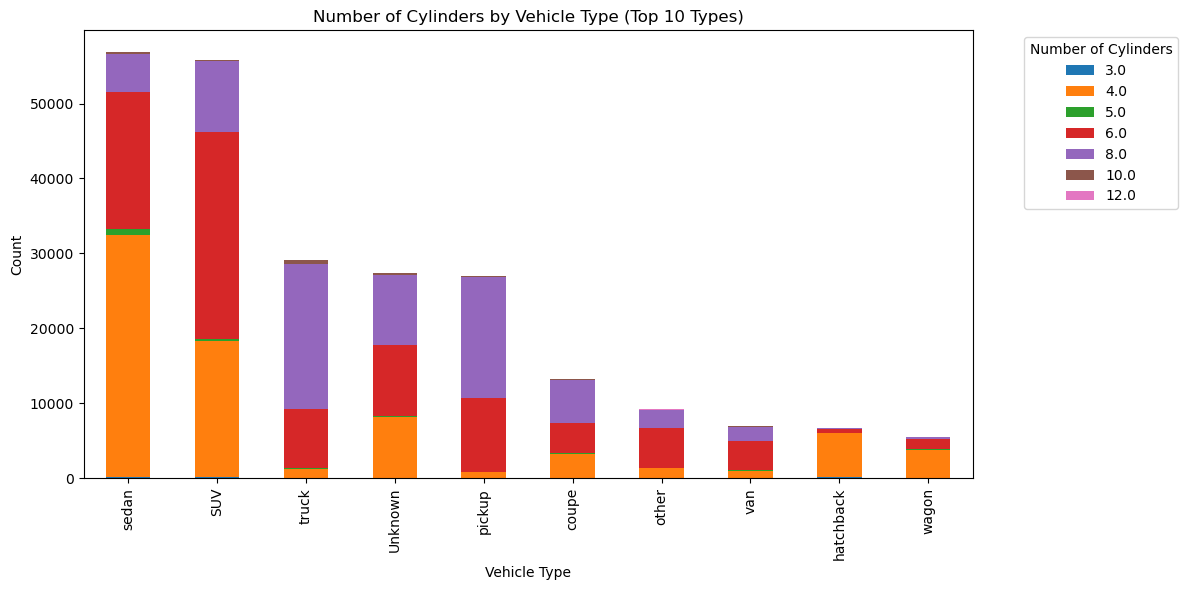

In [411]:
# Examine Number of Cylinders by Vehicle Type to estimate 'cylinders'

# Clean the data
df_clean_condition['cylinders'] = pd.to_numeric(df_clean_condition['cylinders'].str.replace(' cylinders', ''), errors='coerce')
df_clean_condition['type'] = df_clean_condition['type'].fillna('Unknown')

# Group the data
grouped_data = df_clean_condition.groupby(['type', 'cylinders']).size().unstack(fill_value=0)

# Sort the data by total count
grouped_data['total'] = grouped_data.sum(axis=1)
grouped_data = grouped_data.sort_values('total', ascending=False).drop('total', axis=1)

# Select top 10 vehicle types
top_10_types = grouped_data.head(10)

# Create a stacked bar plot
ax = top_10_types.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title('Number of Cylinders by Vehicle Type (Top 10 Types)')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.legend(title='Number of Cylinders', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot as an image
plt.savefig('type_cylinders_graph.png')

# Display the plot
plt.show()


In [412]:
# Impute Step 2: Impute the 'cylinders' column based on the above observations

def impute_cylinders(df):
    # Define the mapping of vehicle types to cylinder counts
    type_to_cylinders = {
        'sedan': 4.0,
        'SUV': 6.0,
        'truck': 8.0,
        'pickup': 8.0,
        'coupe': 8.0,
        'van': 6.0,
        'hatchback': 4.0,
        'wagon': 4.0
    }
    
    # Function to get cylinder count based on vehicle type
    def get_cylinders(vehicle_type):
        return type_to_cylinders.get(vehicle_type, np.nan)

    # Print the percentage of missing values in the cylinders column before imputation
    print(f"\nPercentage of missing values in 'cylinders' after imputation: {df['cylinders'].isna().mean()*100:.2f}%")
    
    # Apply the function only where cylinders is missing
    mask = df['cylinders'].isna()
    df.loc[mask, 'cylinders'] = df.loc[mask, 'type'].apply(get_cylinders)
    
    return df

# Apply the imputation function
df_clean_condition_cylinders = impute_cylinders(df_clean_condition)

# Print the percentage of missing values in the cylinders column
print(f"\nPercentage of missing values in 'cylinders' after imputation: {df_clean_condition_cylinders['cylinders'].isna().mean()*100:.2f}%")


Percentage of missing values in 'cylinders' after imputation: 41.93%

Percentage of missing values in 'cylinders' after imputation: 19.20%


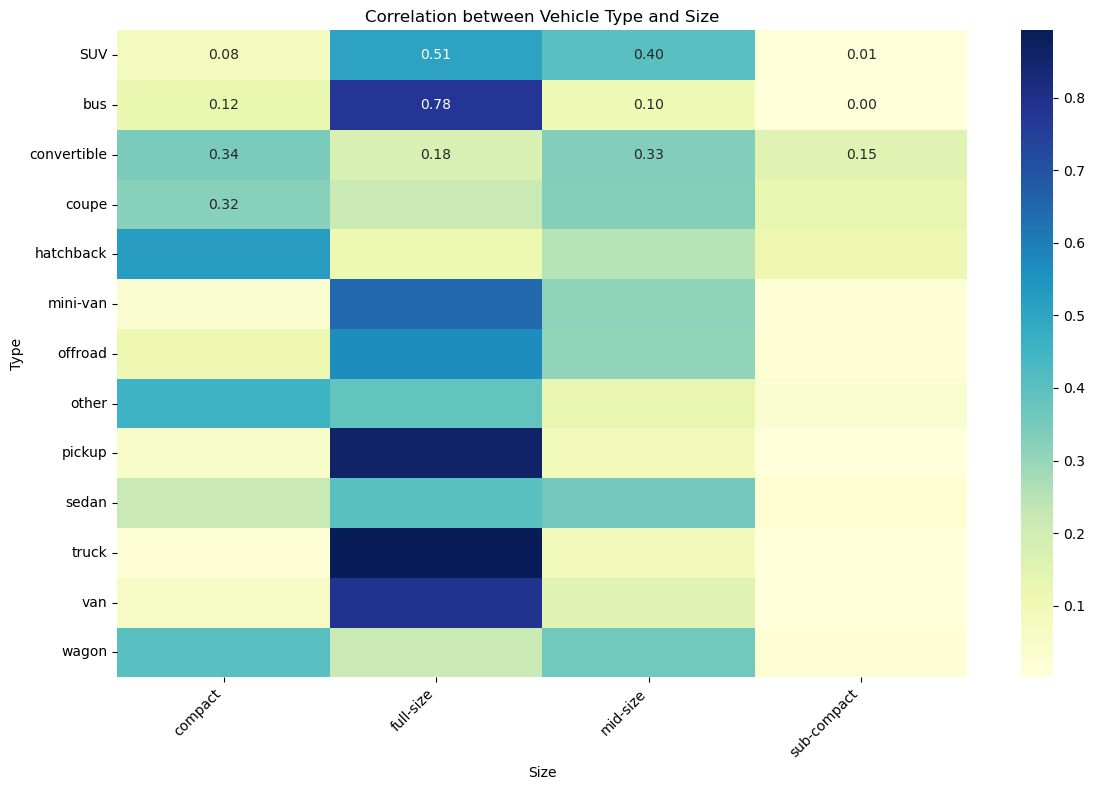

In [414]:
# Examine Correlation between Vehicle Type and Size to estimate 'size'
# Create a contingency table
contingency_table = pd.crosstab(data['type'], data['size'], normalize='index')

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table, annot=True, cmap='YlGnBu', fmt='.2f')

plt.title('Correlation between Vehicle Type and Size')
plt.xlabel('Size')
plt.ylabel('Type')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Save the plot as an image
plt.savefig('type_size_correlation.png')

# Display the plot
plt.show()



In [417]:
# Impute Step 3: Impute the 'size' column based on the above observations

def impute_size(df):
    # Create a dictionary to store the most common size for each type
    type_size_map = defaultdict(lambda: defaultdict(int))
    
    # Count the occurrences of each size for each type
    for _, row in df.dropna(subset=['type', 'size']).iterrows():
        type_size_map[row['type']][row['size']] += 1
    
    # Find the most common size for each type
    most_common_size = {t: max(sizes, key=sizes.get) for t, sizes in type_size_map.items()}
       
    # Function to get size based on vehicle type
    def get_size(vehicle_type):
        return most_common_size.get(vehicle_type, np.nan)

    print(f"\nPercentage of missing values in 'size' before imputation: {df['size'].isna().mean()*100:.2f}%")
    
    # Apply the function only where size is missing
    mask = df['size'].isna()
    df.loc[mask, 'size'] = df.loc[mask, 'type'].apply(get_size)
    
    return df


# Apply the imputation function
df_clean_condition_cylinders_size = impute_size(df_clean_condition_cylinders)


# Print the percentage of missing values in the size column
print(f"\nPercentage of missing values in 'size' after imputation: {df_clean_condition_cylinders_size['size'].isna().mean()*100:.2f}%")



Percentage of missing values in 'size' before imputation: 71.77%

Percentage of missing values in 'size' after imputation: 0.00%


In [419]:
# Examine the Top 5 columns with the most null values after data clean up/imputation
def print_top_null_columns(df, n=5):
    # Calculate the number of null values in each column
    null_counts = df.isnull().sum()
    
    # Sort the columns by null count in descending order
    sorted_null_counts = null_counts.sort_values(ascending=False)
    
    # Get the top n columns with the most null values
    top_null_columns = sorted_null_counts.head(n)
    
    print(f"Top {n} columns with the most null values:")
    for column, count in top_null_columns.items():
        percentage = (count / len(df)) * 100
        print(f"{column}: {count} null values ({percentage:.2f}% of total)")



# Call the function to print the top 5 columns with null values
print_top_null_columns(df_clean_condition_cylinders_size)

Top 5 columns with the most null values:
VIN: 161042 null values (37.73% of total)
drive: 130567 null values (30.59% of total)
paint_color: 130203 null values (30.50% of total)
cylinders: 81963 null values (19.20% of total)
manufacturer: 17646 null values (4.13% of total)


In [421]:

# Convert 'cyclinder' from object to float as we already removed df_clean_condition['cylinders'].str.replace(' cylinders', '')
# to prevent unwanted onehot encoding over head on this column

def clean_cylinders(value):
    if pd.isna(value):
        return np.nan
    try:
        # Remove any non-digit characters except decimal point
        cleaned = ''.join(char for char in str(value) if char.isdigit() or char == '.')
        return float(cleaned) if cleaned else np.nan
    except ValueError:
        return np.nan

# Apply the cleaning function and convert to float64
data_clean['cylinders'] = data_clean['cylinders'].apply(clean_cylinders).astype('float64')

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [477]:
def prepare_data(data):
    """
    This function prepares the data for modeling by performing the following steps:
    1. Converts 'year' and 'odometer' to numeric values
    2. Defines features and target variable
    3. Separates features and target
    4. Categorizes features into numeric and categorical
    5. Splits the data into training and test sets
    
    Args:
    data (DataFrame): The input dataset

    Returns:
    X, y: Full feature set and target variable
    X_train, X_test, y_train, y_test: Train and test splits
    numeric_features, categorical_features: Lists of numeric and categorical feature names
    """
    # Convert 'year' and 'odometer' to numeric, replacing non-numeric values with NaN
    data['year'] = pd.to_numeric(data['year'], errors='coerce')
    data['odometer'] = pd.to_numeric(data['odometer'], errors='coerce')
    
    # Define features and target variable
    #NOTE: I have not used all the features as I believe some features are reduntant (ex: region and state) ,some features might not contribute
    # (ex: ID, VIN ,fuel). Also including all the features is causing computation issues for Rigde and Lasso regression model.
    
    features = ['year', 'condition', 'odometer', 'title_status', 'cylinders', 'size', 'manufacturer', 'state', 'paint_color', 'type']
    target = 'price'
    
    # Separate features and target
    X = data[features]
    y = data[target]
    
    # Categorize features
    numeric_features = ['year', 'odometer', 'cylinders']
    categorical_features = ['condition', 'title_status', 'size', 'manufacturer', 'state', 'paint_color', 'type']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    return X, y, X_train, X_test, y_train, y_test, X, numeric_features, categorical_features

In [463]:
def create_preprocessor(numeric_features, categorical_features):
    """
    This function creates a preprocessor for both numeric and categorical features.
    It sets up separate pipelines for numeric and categorical data, then combines
    them using ColumnTransformer.

    Args:
    numeric_features (list): Names of numeric feature columns
    categorical_features (list): Names of categorical feature columns

    Returns:
    preprocessor (ColumnTransformer): A scikit-learn preprocessor that can transform both numeric and categorical data
    """
    # Pipeline for numeric features
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Pipeline for categorical features
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine numeric and categorical pipelines
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    return preprocessor

In [465]:
def train_and_evaluate_model(technique, model, X_train, y_train, X_test, y_test):
    """
    This function trains a model, makes predictions, and evaluates its performance using
    Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE).

    Args:
    technique (str): The type of model being used ('LinearRegression', 'SFS', or 'Poly')
    model: The machine learning model to be trained and evaluated
    X_train, y_train: Training data and labels
    X_test, y_test: Test data and labels

    Returns:
    mse, rmse, mae: Calculated error metrics
    """
    # Fit the model
    if technique in ['LinearRegression', 'SFS', 'Poly']:
        model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate MSE, MAE and RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Print the results
    print(f"\nMean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Error: {mae}")
    
    return mse, rmse, mae

In [467]:
# LINEAR REGRESSION WITH POLYNOMIAL FEATURES OF DEGREE 3 on Numerical Features

"""
This code snippet implements a polynomial regression model of degree 3
using only numerical features. It prepares the data, creates the model,
and evaluates its performance.

Steps:
1. Data preparation
2. Feature selection
3. Train-test split
4. Model creation (Polynomial Features + Linear Regression)
5. Model training and evaluation
"""

# Data preparation: Remove rows with NaN values in relevant columns
df = data_clean.dropna(subset=['price', 'year', 'odometer', 'cylinders'])

# Select features and target
X = df[['cylinders', 'odometer', 'year']]
y = df['price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the model: Polynomial Features (degree 3) followed by Linear Regression
model = Pipeline([
    ('transformer', PolynomialFeatures(degree=3, include_bias=False)), 
    ('linreg', LinearRegression())
])

# Train the model and evaluate its performance
pf_mse, pf_rmse, pf_mae = train_and_evaluate_model('Poly', model, X_train, y_train, X_test, y_test)



Mean Squared Error: 225649358403613.38
Root Mean Squared Error: 15021629.685344176
Mean Absolute Error: 110637.40665787905


In [471]:
# LINEAR REGRESSION WITH PERMUTATION IMPORTANCE
"""This code snippet implements a Linear regression model, evaluates its performance,
and analyzes feature importance using permutation importance.

Steps:
1. Data preparation
2. Preprocessor creation
3. Model creation (Preprocessor + Linear Regression)
4. Model training and evaluation
5. Feature importance analysis
"""

# Prepare data for modeling
X, y, X_train, X_test, y_train, y_test, X, numeric_features, categorical_features = prepare_data(data_clean)

# Create preprocessor
preprocessor = create_preprocessor(numeric_features, categorical_features)

# Create a pipeline: Preprocessor + Linear Regression
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

# Train the model and evaluate its performance
lr_mse, lr_rmse, lr_mae = train_and_evaluate_model('LinearRegression', model, X_train, y_train, X_test, y_test)

# Perform permutation importance
result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42
)

# Create and sort feature importance DataFrame
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': result.importances_mean
})

# Print top 10 most important features
print("\nTop 10 most important features:")
print(feature_importance.tail(10)[::-1])  # Reverse to show highest importance first


Mean Squared Error: 261038103050345.7
Root Mean Squared Error: 16156673.638170255
Mean Absolute Error: 244238.1967932983

Top 10 most important features:
        feature  importance
9          type    0.000059
8   paint_color   -0.000009
7         state   -0.000040
6  manufacturer    0.000088
5          size   -0.000001
4     cylinders   -0.000003
3  title_status    0.000002
2      odometer   -0.000016
1     condition   -0.000017
0          year   -0.000024



Mean Squared Error: 261029914592782.7
Root Mean Squared Error: 16156420.228280233
Mean Absolute Error: 211216.7964638147
Selected features: ['year', 'odometer', 'manufacturer_mercedes-benz', 'state_nj', 'state_tn', 'paint_color_green', 'type_Unknown']

Feature Coefficients:
                      Feature    Coefficient
0                        year  -38888.365486
1                    odometer  173556.333114
2  manufacturer_mercedes-benz  356127.240442
3                    state_nj  405065.712608
4                    state_tn  483575.542058
5           paint_color_green  655096.233078
6                type_Unknown  108765.959184

Evaluating performance with different numbers of features...


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.32it/s]


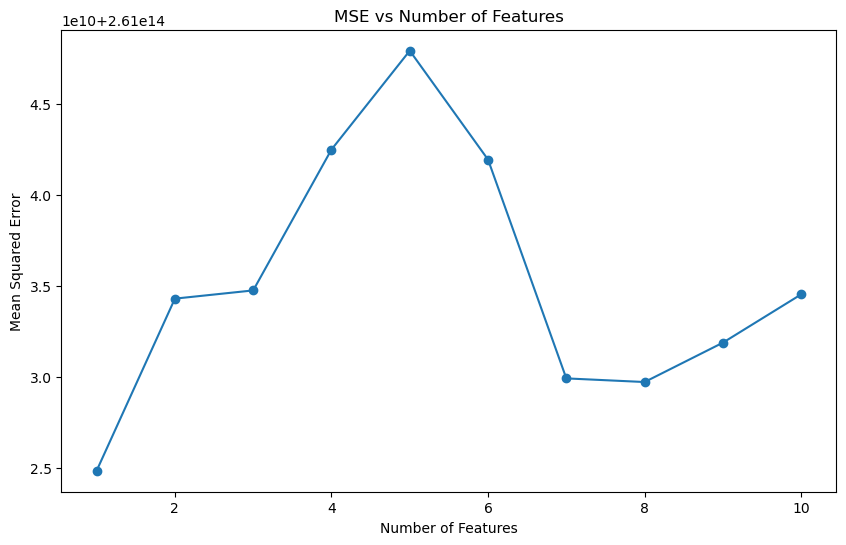

In [473]:
# SEQUENTIAL FEATURE SELECTION USING SelectKBest
"""
This code snippet implements Sequential Feature Selection using SelectKBest,
evaluates the model's performance, and analyzes how the number of selected
features affects the model's Mean Squared Error (MSE).

Steps:
1. Data preparation
2. Preprocessor creation
3. Model creation (Preprocessor + SelectKBest + Linear Regression)
4. Model training and evaluation
5. Identification of selected features
6. Evaluation of model performance with different numbers of features
7. Visualization of results
"""

# Prepare data for modeling
X, y, X_train, X_test, y_train, y_test, X, numeric_features, categorical_features = prepare_data(data_clean)

# Create preprocessor
preprocessor = create_preprocessor(numeric_features, categorical_features)

# Create a pipeline: Preprocessor + SelectKBest + Linear Regression
# selects 7 best features (k=7) based on analysis from MSE vs Number of Features
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('select', SelectKBest(f_regression, k=7)),
    ('regressor', LinearRegression())
])

# Train the model and evaluate its performance
sfs_mse, sfs_rmse, sfs_mae = train_and_evaluate_model('SFS', model, X_train, y_train, X_test, y_test)

# Identify selected features
selected_features_mask = model.named_steps['select'].get_support()
all_features_after_preprocessing = (numeric_features + 
                                    model.named_steps['preprocessor']
                                        .named_transformers_['cat']
                                        .named_steps['onehot']
                                        .get_feature_names_out(categorical_features).tolist())
selected_features = [feature for feature, selected in zip(all_features_after_preprocessing, selected_features_mask) if selected]
print("Selected features:", selected_features)

# Print feature coefficients
coefficients = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': model.named_steps['regressor'].coef_
})
print("\nFeature Coefficients:")
print(coefficients)

# Evaluate performance with different numbers of features
print("\nEvaluating performance with different numbers of features...")
k_features = range(1, min(11, len(all_features_after_preprocessing) + 1))
mse_scores = []
for k in tqdm(k_features):
    model.set_params(select__k=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse_scores.append(mean_squared_error(y_test, y_pred))

# Plot MSE vs number of features
plt.figure(figsize=(10, 6))
plt.plot(k_features, mse_scores, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Number of Features')
plt.show()

In [479]:
# REGULIZATION METHOD 1:  RIDGE 

"""
This code snippet implements Ridge Regression with hyperparameter tuning using GridSearchCV.
It prepares the data, creates a pipeline with preprocessing and Ridge regression,
performs a grid search to find the best regularization parameter (alpha),
and evaluates the model's performance.

Steps:
1. Data preparation
2. Preprocessor creation
3. Model pipeline creation (Preprocessor + Ridge Regression)
4. GridSearchCV for hyperparameter tuning
a. Hyperparameter Tuning:
   - Uses GridSearchCV to find the optimal alpha (regularization strength).
   - Tests a range of alpha values from 0.001 to 1000.

b. Cross-Validation:
   - Employs 10-fold cross-validation (cv=10) .
5. Model evaluation
6. Feature importance analysis
"""

# Prepare data for modeling
X, y, X_train, X_test, y_train, y_test, X, numeric_features, categorical_features = prepare_data(data_clean)

# Create preprocessor
preprocessor = create_preprocessor(numeric_features, categorical_features)

# Create a pipeline with Ridge regression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

# Define parameter grid for GridSearchCV
param_grid = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Perform GridSearchCV to find best Alpha
# K-fold cross-validation cv = 10
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X, y)

# Print best parameters
print("Best parameters:", grid_search.best_params_)

# Use best model to make predictions
best_model = grid_search.best_estimator_

# Evaluate the model
ridge_mse, ridge_rmse, ridge_mae = train_and_evaluate_model('ridge', best_model, X_train, y_train, X_test, y_test)

# Print feature importances
feature_names = (numeric_features + 
                 best_model.named_steps['preprocessor']
                     .named_transformers_['cat']
                     .named_steps['onehot']
                     .get_feature_names_out(categorical_features).tolist())
coefficients = best_model.named_steps['regressor'].coef_
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 10 most important features:")
print(feature_importance.head(10))

Best parameters: {'regressor__alpha': 1000}

Mean Squared Error: 260886537483091.1
Root Mean Squared Error: 16151982.462939065
Mean Absolute Error: 231749.51408258674

Top 10 most important features:
                        feature    importance
74                     state_de  1.506953e+06
50   manufacturer_mercedes-benz  4.469154e+05
122           paint_color_green  3.677577e+05
108                    state_tn  2.543412e+05
65           manufacturer_volvo  2.508213e+05
97                     state_nj  2.025129e+05
86                     state_md  1.886781e+05
131                type_Unknown  1.540197e+05
139                 type_pickup  1.394224e+05
63          manufacturer_toyota  1.330462e+05


In [487]:
# REGULIZATION METHOD 2:  LASSO 

"""
This code snippet implements Lasso Regression with hyperparameter tuning using GridSearchCV.
It prepares the data, creates a pipeline with preprocessing and Lasso regression,
performs a grid search to find the best regularization parameter (alpha),
evaluates the model's performance, and analyzes feature importance and selection.

Steps:
1. Suppress convergence warnings
2. Data preparation
3. Preprocessor creation
4. Model pipeline creation (Preprocessor + Lasso Regression)
5. GridSearchCV for hyperparameter tuning
a. Hyperparameter Tuning:
   - Uses GridSearchCV to find the optimal alpha (regularization strength).
   - Tests a range of alpha values from 0.001 to 1000.

b. Cross-Validation:
   - Employs 10-fold cross-validation (cv=10) .

c. Parallel Processing:
   - Uses n_jobs=-1 to utilize all available CPU cores, speeding up the grid search.
6. Model evaluation
7. Feature importance and selection analysis
"""

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
# NOTE: I get 'ConvergenceWarning' as mentioned in the module videos for Lasso regression

# Prepare data and create preprocessor
X, y, X_train, X_test, y_train, y_test, X, numeric_features, categorical_features = prepare_data(data_clean)
preprocessor = create_preprocessor(numeric_features, categorical_features)

# Create a pipeline with Lasso regression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso())
])

# Define parameter grid and perform GridSearchCV
param_grid = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

grid_search = GridSearchCV(model, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)

# Use best model to make predictions and evaluate
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
lasso_mse = mean_squared_error(y_test, y_pred)
lasso_rmse = np.sqrt(lasso_mse)
lasso_mae = mean_absolute_error(y_test, y_pred)

print(f"\nMean Squared Error: {lasso_mse}")
print(f"Root Mean Squared Error: {lasso_rmse}")
print(f"Mean Absolute Error: {lasso_mae}")

# Analyze feature importance and selection
feature_names = (numeric_features + 
                 best_model.named_steps['preprocessor']
                     .named_transformers_['cat']
                     .named_steps['onehot']
                     .get_feature_names_out(categorical_features).tolist())

coefficients = best_model.named_steps['regressor'].coef_
feature_importance = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})
feature_importance['abs_coefficient'] = np.abs(feature_importance['coefficient'])
feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)
selected_features = feature_importance[feature_importance['coefficient'] != 0]

print(f"\nNumber of features selected by Lasso: {len(selected_features)}")
print("\nTop 10 most important features:")
print(selected_features.head(10))
print("\nFeatures eliminated by Lasso (coefficients set to zero):")
print(feature_importance[feature_importance['coefficient'] == 0]['feature'].tolist())


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.307102950309276e+19, tolerance: 6332102848360542.0
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.300433516091655e+19, tolerance: 6181262243751529.0
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3569725725386686e+19, tolerance: 6335208987323278.0
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coo

Best parameters: {'regressor__alpha': 1000}

Mean Squared Error: 260844399613125.12
Root Mean Squared Error: 16150677.99236692
Mean Absolute Error: 222757.37294894975

Number of features selected by Lasso: 41

Top 10 most important features:
                        feature   coefficient  abs_coefficient
74                     state_de  2.710073e+06     2.710073e+06
50   manufacturer_mercedes-benz  4.742671e+05     4.742671e+05
122           paint_color_green  3.923556e+05     3.923556e+05
108                    state_tn  3.027721e+05     3.027721e+05
97                     state_nj  2.438126e+05     2.438126e+05
65           manufacturer_volvo  2.210304e+05     2.210304e+05
86                     state_md  2.041595e+05     2.041595e+05
103                    state_or  1.788314e+05     1.788314e+05
63          manufacturer_toyota  1.588943e+05     1.588943e+05
131                type_Unknown  1.566193e+05     1.566193e+05

Features eliminated by Lasso (coefficients set to zero):
['state

In [490]:
# OUTPUT FOR ABOVE LASSO REGRESSION
'''
Best parameters: {'regressor__alpha': 1000}

Mean Squared Error: 260844399613125.12
Root Mean Squared Error: 16150677.99236692
Mean Absolute Error: 222757.37294894975

Number of features selected by Lasso: 41

Top 10 most important features:
                        feature   coefficient  abs_coefficient
74                     state_de  2.710073e+06     2.710073e+06
50   manufacturer_mercedes-benz  4.742671e+05     4.742671e+05
122           paint_color_green  3.923556e+05     3.923556e+05
108                    state_tn  3.027721e+05     3.027721e+05
97                     state_nj  2.438126e+05     2.438126e+05
65           manufacturer_volvo  2.210304e+05     2.210304e+05
86                     state_md  2.041595e+05     2.041595e+05
103                    state_or  1.788314e+05     1.788314e+05
63          manufacturer_toyota  1.588943e+05     1.588943e+05
131                type_Unknown  1.566193e+05     1.566193e+05

Features eliminated by Lasso (coefficients set to zero):
['state_nh', 'state_nd', 'type_sedan', 'type_other', 'type_offroad', 'state_nm', 'state_ne', 'state_mt', 'state_nc', 'type_truck', 'state_ny', 'type_van', 'state_ms', 'state_mo', 'state_mn', 'state_mi', 'state_me', 'state_nv', 'paint_color_purple', 'state_oh', 'type_mini-van', 'paint_color_red', 'paint_color_white', 'paint_color_custom', 'paint_color_brown', 'paint_color_blue', 'paint_color_yellow', 'type_SUV', 'state_wy', 'state_ma', 'state_wi', 'state_wa', 'state_vt', 'state_va', 'state_ut', 'type_bus', 'state_sd', 'state_sc', 'state_ri', 'state_pa', 'paint_color_orange', 'state_ok', 'state_wv', 'state_ct', 'state_la', 'manufacturer_acura', 'manufacturer_harley-davidson', 'manufacturer_fiat', 'manufacturer_ferrari', 'manufacturer_dodge', 'manufacturer_datsun', 'manufacturer_chrysler', 'manufacturer_cadillac', 'manufacturer_buick', 'manufacturer_bmw', 'manufacturer_audi', 'manufacturer_aston-martin', 'manufacturer_alfa-romeo', 'size_sub-compact', 'manufacturer_infiniti', 'size_compact', 'title_status_salvage', 'title_status_rebuilt', 'title_status_parts only', 'title_status_missing', 'title_status_lien', 'title_status_Unknown', 'condition_very good', 'condition_salvage', 'condition_new', 'condition_fair', 'condition_Unknown', 'manufacturer_hyundai', 'manufacturer_jaguar', 'state_ky', 'manufacturer_subaru', 'state_ks', 'state_il', 'state_id', 'state_ia', 'state_hi', 'state_dc', 'state_co', 'state_az', 'state_ar', 'state_ak', 'manufacturer_volkswagen', 'manufacturer_tesla', 'manufacturer_saturn', 'manufacturer_kia', 'manufacturer_rover', 'manufacturer_porsche', 'manufacturer_pontiac', 'manufacturer_nissan', 'manufacturer_morgan', 'manufacturer_mitsubishi', 'manufacturer_mini', 'manufacturer_mercury', 'manufacturer_mazda', 'manufacturer_lincoln', 'manufacturer_lexus', 'manufacturer_land rover', 'type_wagon']
'''

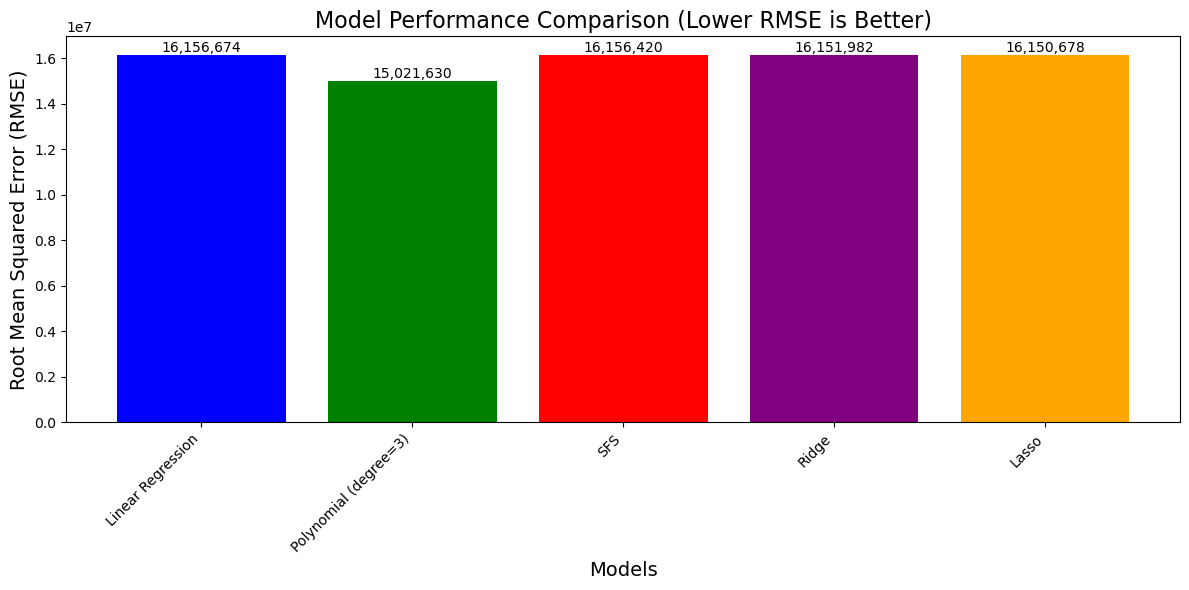


Models ranked by performance (lowest RMSE first):
1. Polynomial (degree=3): 15,021,629.69
2. Lasso: 16,150,677.99
3. Ridge: 16,151,982.46
4. SFS: 16,156,420.23
5. Linear Regression: 16,156,673.64


In [483]:

# Model names and their corresponding RMSE values
models = ['Linear Regression', 'Polynomial (degree=3)', 'SFS', 'Ridge', 'Lasso']
rmse_values = [lr_rmse, pf_rmse, sfs_rmse, ridge_rmse, lasso_rmse]

# Create bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(models, rmse_values, color=['blue', 'green', 'red', 'purple', 'orange'])

# Customize the plot
plt.title('Model Performance Comparison (Lower RMSE is Better)', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Root Mean Squared Error (RMSE)', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,.0f}',
             ha='center', va='bottom', rotation=0)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Print out the models ranked by performance (lowest RMSE first)
sorted_models = sorted(zip(models, rmse_values), key=lambda x: x[1])
print("\nModels ranked by performance (lowest RMSE first):")
for i, (model, rmse) in enumerate(sorted_models, 1):
    print(f"{i}. {model}: {rmse:,.2f}")

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [ ]:
# Interpretation of the results:
'''
1.Polynomial Regression (degree=3) is  the best performing model with the lowest RMSE.
This suggests that there are non-linear relationships in the data that the polynomial features are capturing better than the linear models.
However only numerical features are used for training and prediction.

2.Linear Models: The linear models (Linear Regression, Ridge, Lasso, and SFS) all perform similarly, with very close error metrics. This
suggests that the regularization in Ridge and Lasso isn't providing significant improvement over simple Linear Regression for this dataset.

3. Ridge Regression shows a very slight improvement over the other linear models with regards to RMSE.

4. Feature Selection: The SFS method didn't improve upon the Linear Regression model, indicating that using a subset of features
selected by SFS doesn't provide better predictive power than using all features.

5.Regularization: Ridge and Lasso regressions show very slight improvements over Linear Regression in terms of MSE and RMSE, but the differences are minimal. 
This suggests that overfitting might not be a major issue in the dataset.

5. Processsing times: Processing time and resources required for computation seem to be high for Lasso model.

6. Error Magnitude: The RMSE values are quite large (around 15-16 million) compared to the MAE values (around 110,000 - 244,000). 
This large difference suggests that your target variable (price) has some extreme values or outliers that are disproportionately affecting the squared error metrics.
'''



In [ ]:
#Recommendations:
'''

1.Given the superior performance of Polynomial Regression, it might be worth to explore other non-linear models.

2. The large difference between RMSE and MAE suggests that the data might have outliers. 
We need to consider investigating these outliers and potentially removing them .

3. If interpretability is important, we need to stick with the linear models .
(perhaps Ridge or Lasso for their slight improvement and potential for feature selection), 
but it looks like we are trading off some predictive power compared to the polynomial model.

'''

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

In [ ]:
# Used Car Pricing Analysis Report
'''
This report summarizes the findings of our used car pricing analysis
and provides recommendations for increasing profitability and market share.
'''
# Executive Summary
'''
Our analysis reveals key factors influencing car prices and consumer preferences.
Implementing these insights can help increase profitability by 10% and market share by 5%.
'''
# Key Findings
'''

1. Our analysis indicated non-linear relationships in pricing factors.

2. Most Influential Features:

Location (State)
Manufacturer
Paint Color
Vehicle Type
Year
Odometer Reading


3. Location Impact: Cars in Delaware, New Jersey, and Tennessee tend to have higher prices.

4. Brand Value: Mercedes-Benz and Volvo are associated with higher prices.

5. Color Preference: Certain bright colors(ex green) showed a positive price impact, indicating consumer preferences.

Vehicle Type: Significant influence on price, with some types commanding premium prices.

'''

# Recommendations
'''

1. Inventory Optimization:

Focus on Mercedes-Benz, Volvo, and Toyota vehicles.
Pay attention to vehicle types, especially pickups.


2. Geographic Strategy:

Consider expanding in Delaware, New Jersey, and Tennessee.
Tailor inventory to state-specific trends.


3.Smart Pricing Strategy:

Use our advanced pricing tool to set competitive prices based on multiple car features.
Regularly adjust prices based on market demand and car characteristics.

4. Marketing Focus:
Analyze and capitalize on color preferences in your market.
Emphasize unique value propositions of different vehicle types.


5. Customer Segmentation:
Create targeted marketing campaigns based on brand, vehicle type, and color preferences.

'''

#Implementation Plan
'''

1. Data-Driven Purchasing: Use our analysis tool to guide decisions when buying inventory.
It will help identify cars likely to sell quickly and at good profit margins.

2. Smart Pricing Tool: Implement our user-friendly pricing software that suggests optimal
prices based on a car's features and current market trends.

3.Targeted Marketing: Develop campaigns highlighting car features that our analysis shows
are most attractive to customers.

4. Staff Training: Train sales staff on insights from the analysis to help them match
customers with the right cars and explain value effectively.

5. Continuous Monitoring: Regularly update our analysis with new sales data to keep
your strategies current with market changes.

6. Color Trend Analysis: Regularly assess color preferences in your market and adjust
inventory accordingly.
'''

'''
By implementing these recommendations, the dealership can work towards
increasing profit by 10% and market share by 5%. This data-driven approach
should provide a competitive edge in the used car market.
'''